#### IMPORTAÇÕES

In [1]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import zscore

- Tratar os dados, removendo os outliers do início e fim de cada ciclo
- Separar um ciclo com base no primeiro menor valor de voltagem e o próximo valor menor que ele (automatizar)
- Identificar os pontos de mínimo e máximo locais
- Obter o maior ponto de mínimo e o menor ponto de máximo
- Fazer integração da região delimitada por esses pontos para obter a área

#### LEITURA DO ARQUIVO

        #Time[s]  Current[A]  Voltage[V]  SyncADCs[V]
0       0.161152   -0.000055    0.009257     0.000156
1       0.229208   -0.000027    0.005732     0.000159
2       0.295062   -0.000021    0.009032     0.000157
3       0.433713   -0.000015    0.015597     0.000141
4       0.565311   -0.000013    0.022140     0.000143
...          ...         ...         ...          ...
4545  354.487224   -0.000006   -0.238133     0.000173
4546  354.553086   -0.000007   -0.241379     0.000162
4547  354.708825   -0.000008   -0.251201     0.000161
4548  354.849726   -0.000010   -0.257650     0.000148
4549  354.915756    0.000025   -0.242106     0.000150

[4550 rows x 4 columns]


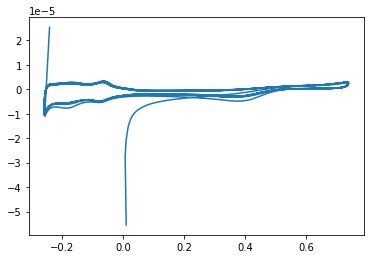

In [2]:
file = "Pt electrode 01-02-2024_11_06_02_Example.txt"

df = pd.read_csv(file, sep = '\s+', engine='python', header=0)
print(df)

plt.plot(df.iloc[:,2], df.iloc[:,1])

#### TRATAMENTO DOS DADOS

        #Time[s]  Current[A]  Voltage[V]  SyncADCs[V]
11      1.063979   -0.000009    0.045000     0.000153
12      1.148584   -0.000008    0.051563     0.000168
13      1.214621   -0.000008    0.054836     0.000160
14      1.351024   -0.000007    0.061372     0.000157
15      1.426881   -0.000007    0.064670     0.000158
...          ...         ...         ...          ...
4543  354.351766   -0.000006   -0.231589     0.000167
4544  354.417108   -0.000006   -0.234877     0.000178
4545  354.487224   -0.000006   -0.238133     0.000173
4546  354.553086   -0.000007   -0.241379     0.000162
4547  354.708825   -0.000008   -0.251201     0.000161

[4519 rows x 4 columns]


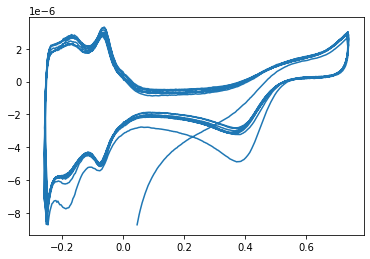

In [3]:
# Calcula o Z-score para voltagem e corrente
z_scores = zscore(df[['Voltage[V]', 'Current[A]']])

# Define um limiar de Z-score para identificar outliers
limiar_z_score = 3

# Cria uma máscara para identificar os outliers
outliers_mask = (abs(z_scores) > limiar_z_score).any(axis=1)

# Remove outliers
df_sem_outliers = df[~outliers_mask]

print(df_sem_outliers)
plt.plot(df_sem_outliers.iloc[:,2], df_sem_outliers.iloc[:,1])

#### CICLO VOLTAMÉTRICO COM AS REGIÇÕES DE INTERESSE

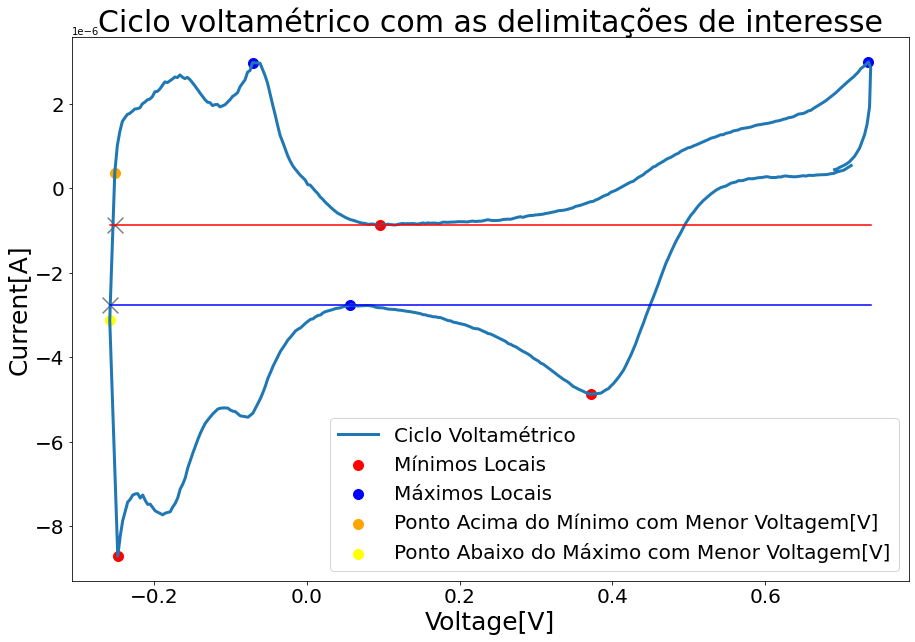

In [4]:
# Identifica um intervalo que contenha apenas um ciclo de voltametria
ciclo_df = df_sem_outliers.iloc[185:705, [2, 1]]

# Encontra pontos de mínimo e máximo locais na corrente
minimos_locais = argrelextrema(ciclo_df['Current[A]'].values, np.less, order=50)[0]
maximos_locais = argrelextrema(ciclo_df['Current[A]'].values, np.greater, order=50)[0]

# Encontra o par de pontos com a menor diferença no eixo y
ponto_min_diferenca = None
min_diferenca = float('inf')

for minimo_idx in minimos_locais:
    for maximo_idx in maximos_locais:
        diferenca_y = abs(ciclo_df['Current[A]'].iloc[minimo_idx] - ciclo_df['Current[A]'].iloc[maximo_idx])
        if diferenca_y < min_diferenca:
            min_diferenca = diferenca_y
            ponto_min_diferenca = (minimo_idx, maximo_idx)

# Coordenadas do par de pontos com a menor diferença no eixo y
minimo_idx, maximo_idx = ponto_min_diferenca

# Encontra o ponto acima da linha horizontal referente ao ponto minimo_idx com o menor valor de Voltage[V]
ponto_acima_minimo = ciclo_df[ciclo_df['Current[A]'] > ciclo_df['Current[A]'].iloc[minimo_idx]].loc[
    ciclo_df[ciclo_df['Current[A]'] > ciclo_df['Current[A]'].iloc[minimo_idx]]['Voltage[V]'].idxmin()]

# Encontra o ponto abaixo da linha horizontal referente ao ponto maximo_idx com o menor valor de Voltage[V]
ponto_abaixo_maximo = ciclo_df[ciclo_df['Current[A]'] < ciclo_df['Current[A]'].iloc[maximo_idx]].loc[
    ciclo_df[ciclo_df['Current[A]'] < ciclo_df['Current[A]'].iloc[maximo_idx]]['Voltage[V]'].idxmin()]

# Marca os pontos de máximo e mínino no ciclo voltamétrico
plt.figure(figsize = (15, 10))
plt.plot(ciclo_df['Voltage[V]'], ciclo_df['Current[A]'], label='Ciclo Voltamétrico', linewidth=3)
plt.scatter(ciclo_df['Voltage[V]'].iloc[minimos_locais], ciclo_df['Current[A]'].iloc[minimos_locais], c='red', marker='o', label='Mínimos Locais', s=100)
plt.scatter(ciclo_df['Voltage[V]'].iloc[maximos_locais], ciclo_df['Current[A]'].iloc[maximos_locais], c='blue', marker='o', label='Máximos Locais', s=100)

# Marca os pontos de referência para o menor valor de voltagem com base em cada linha horizontal
plt.scatter(ponto_acima_minimo['Voltage[V]'], ponto_acima_minimo['Current[A]'], c='orange', marker='o', label='Ponto Acima do Mínimo com Menor Voltagem[V]', s=100)
plt.scatter(ponto_abaixo_maximo['Voltage[V]'], ponto_abaixo_maximo['Current[A]'], c='yellow', marker='o', label='Ponto Abaixo do Máximo com Menor Voltagem[V]', s=100)

interval = np.linspace(min(ciclo_df['Voltage[V]']), max(ciclo_df['Voltage[V]']), 1000)

# Gera a representação das linhas horizontais

constante_min = []
constante_max = []

for i in range(len(interval)):
    i = ciclo_df['Current[A]'].iloc[minimo_idx]
    constante_min.append(i)

for j in range(len(interval)):
    j = ciclo_df['Current[A]'].iloc[maximo_idx]
    constante_max.append(j)
    
ponto_acima = ponto_acima_minimo['Voltage[V]']

# Faz a interpolação com os pontos de menor voltagem em relação à linha horizontal

f = interp1d(interval, constante_min)
limite_inicial_cima = f(ponto_acima)

ponto_abaixo = ponto_abaixo_maximo['Voltage[V]']

f = interp1d(interval, constante_max)
limite_inicial_baixo = f(ponto_abaixo)

# Representação gráfica das linhas e dos pontos interpolados
        
plt.plot(interval, constante_min, color = 'red')
plt.plot(interval, constante_max, color = 'blue')

plt.scatter(ponto_acima_minimo['Voltage[V]'], limite_inicial_cima, marker = 'x', color = 'gray', s=250)
plt.scatter(ponto_abaixo_maximo['Voltage[V]'], limite_inicial_baixo, marker = 'x', color = 'gray', s=250)

plt.rcParams['legend.fontsize'] = 20
plt. tick_params(labelsize=20)
plt.xlabel('Voltage[V]', size=25)
plt.ylabel('Current[A]', size=25)
plt.title('Ciclo voltamétrico com as delimitações de interesse', size=30)
plt.legend()
plt.show()

#### CÁLCULO DA ÁREA ACIMA E ABAIXO DAS LINHAS HORIZONTAIS DE REFERÊNCIA

7.52742881695373e-07
7.527428816953727e-07


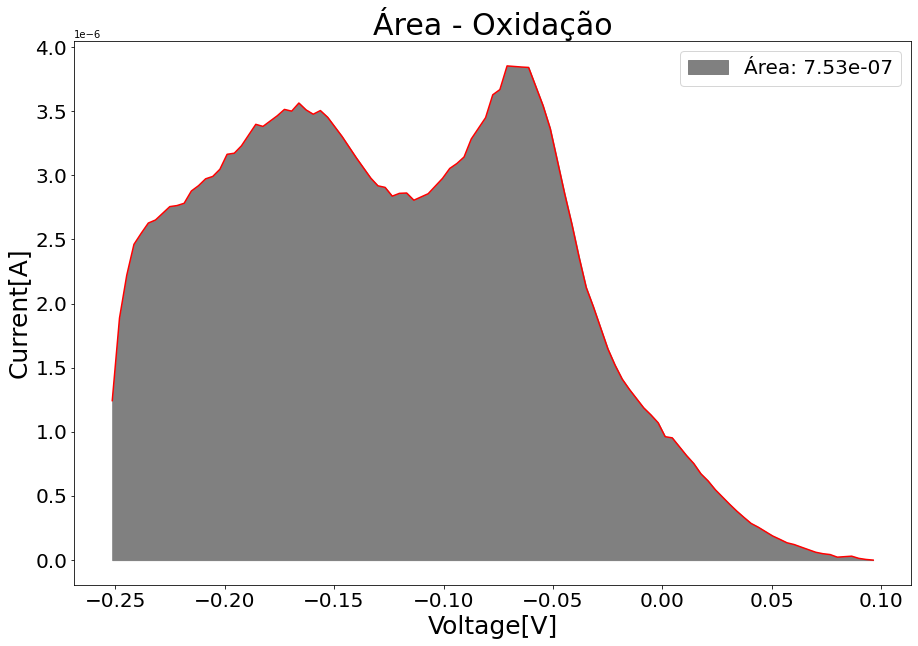

In [5]:
# Delimitação da região de interesse para o cálculo da área

valor_procurado_inicio_cima = ponto_acima_minimo['Voltage[V]']
indice_inicio_cima = ciclo_df[ciclo_df['Voltage[V]'] == valor_procurado_inicio_cima].index.tolist()
valor_procurado_fim_cima = ciclo_df['Voltage[V]'].iloc[minimo_idx]
indice_fim_cima = ciclo_df[ciclo_df['Voltage[V]'] == valor_procurado_fim_cima].index.tolist()

x_cima = ciclo_df.loc[indice_inicio_cima[0]:indice_fim_cima[0], 'Voltage[V]']
y_cima = ciclo_df.loc[indice_inicio_cima[0]:indice_fim_cima[0], 'Current[A]']
y0_cima = y_cima-min(y_cima)  # shift dos valores de corrente para o eixo 0 para obter a área

x_list_cima = list(x_cima)
y_list_cima = list(y0_cima)

# Representação gráfica

plt.figure(figsize = (15, 10))
plt.plot(x_cima, y0_cima, color='red')

# Aplicação do método do trapézio para o cálculo da área

area_cima = np.trapz(y0_cima, x_cima)
print(area_cima)

lista_trapezio_cima = []

for j, k in zip(range(len(list(x_list_cima))-1), range(len(list(y_list_cima))-1)):
        valor = (y_list_cima[k+1] + y_list_cima[k]) * (x_list_cima[j+1] - x_list_cima[j])/2
        lista_trapezio_cima.append(valor)
        
area_sob_curva_cima = sum(lista_trapezio_cima)
print(area_sob_curva_cima)
plt.fill_between(x_cima, y0_cima, color='gray', alpha=1, label=f'Área: {area_sob_curva_cima:.2e}')
plt.rcParams['legend.fontsize'] = 20
plt. tick_params(labelsize=20)
plt.xlabel('Voltage[V]', size=25)
plt.ylabel('Current[A]', size=25)
plt.title('Área - Oxidação', size=30)
plt.legend(loc='upper right')
plt.show()

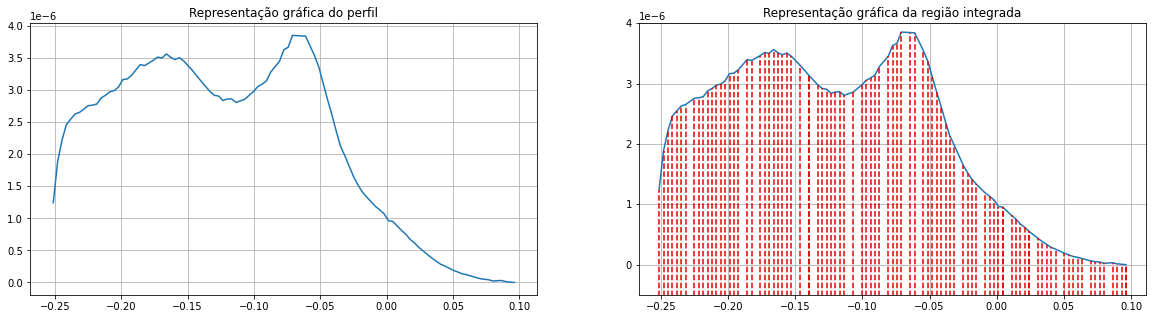

In [6]:
# Representação da região de integração

plt.figure(figsize = (20, 5))
plt.subplot(1, 2, 1)
plt.plot(x_list_cima, y_list_cima)
plt.title('Representação gráfica do perfil')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(x_list_cima, y_list_cima)
for i in range(len(x_list_cima)):
    j+=1
    plt.plot([x_list_cima[i], x_list_cima[i]], [x_list_cima[0], y_list_cima[i]], color='#E50000', linestyle='--')
while j < len(x_list_cima):
    plt.plot([x_list_cima[i+j], x_list_cima[i+j]], [x_list_cima[0], y_list_cima[i+j]], color='#E50000', linestyle='--')
plt.plot([x_list_cima[-1], x_list_cima[-1]], [x_list_cima[0], y_list_cima[-1]], color='#E50000', linestyle='--')
plt.xlim(min(x_list_cima)-0.015, max(x_list_cima)+0.015)
plt.ylim(min(y_list_cima)-0.0000005, max(y_list_cima)+0.00000015)
plt.title('Representação gráfica da região integrada')
plt.grid()
plt.show()

8.011244980580234e-07
8.011244980580234e-07


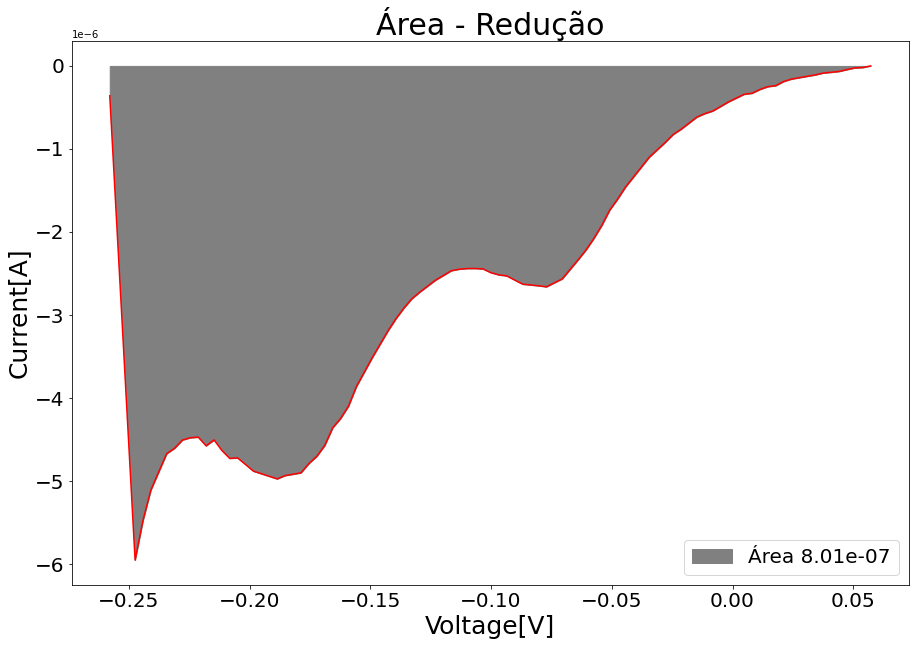

In [7]:
# Delimitação da região de interesse para o cálculo da área

valor_procurado_inicio_baixo = ponto_abaixo_maximo['Voltage[V]']
indice_inicio_baixo = ciclo_df[ciclo_df['Voltage[V]'] == valor_procurado_inicio_baixo].index.tolist()
valor_procurado_fim_baixo = ciclo_df['Voltage[V]'].iloc[maximo_idx]
indice_fim_baixo = ciclo_df[ciclo_df['Voltage[V]'] == valor_procurado_fim_baixo].index.tolist()

x_baixo = ciclo_df.loc[indice_fim_baixo[0]:indice_inicio_baixo[0], 'Voltage[V]']
y_baixo = ciclo_df.loc[indice_fim_baixo[0]:indice_inicio_baixo[0], 'Current[A]']
y0_baixo = y_baixo-max(y_baixo) # shift dos valores de corrente para o eixo 0 para obter a área

x_list_baixo = list(x_baixo)
y_list_baixo = list(y0_baixo)

# Representação gráfica

plt.figure(figsize = (15, 10))
plt.plot(x_baixo, y0_baixo, color='red')

# Aplicação do método do trapézio para o cálculo da área

area_baixo = np.trapz(y0_baixo, x_baixo)
print(area_baixo)

lista_trapezio_baixo = []

for j, k in zip(range(len(list(x_list_baixo))-1), range(len(list(y_list_baixo))-1)):
        valor = (y_list_baixo[k+1] + y_list_baixo[k]) * (x_list_baixo[j+1] - x_list_baixo[j])/2
        lista_trapezio_baixo.append(valor)
        
area_sob_curva_baixo = sum(lista_trapezio_baixo)
print(area_sob_curva_baixo)

plt.fill_between(x_baixo, y0_baixo, color='gray', alpha=1, label=f'Área {area_sob_curva_baixo:.2e}')
plt.rcParams['legend.fontsize'] = 20
plt. tick_params(labelsize=20)
plt.xlabel('Voltage[V]', size=25)
plt.ylabel('Current[A]', size=25)
plt.title('Área - Redução', size=30)
plt.legend(loc='lower right')
plt.show()

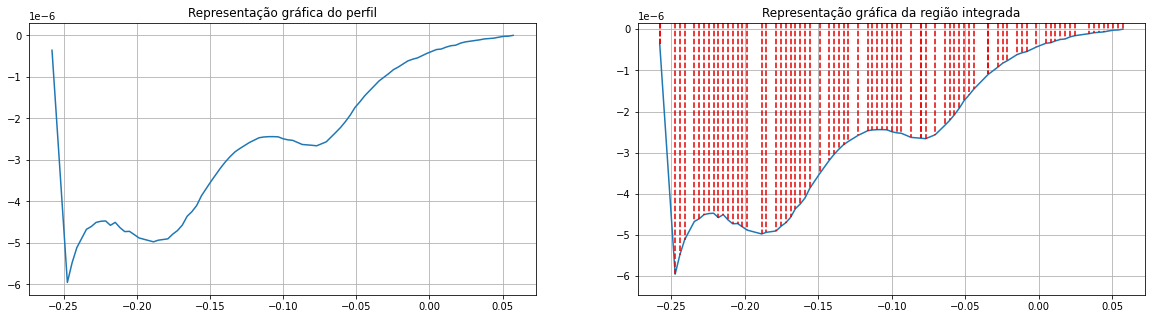

In [8]:
# Representação da região de integração

plt.figure(figsize = (20, 5))
plt.subplot(1, 2, 1)
plt.plot(x_list_baixo, y_list_baixo)
plt.title('Representação gráfica do perfil')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(x_list_baixo, y_list_baixo)
for i in range(len(x_list_baixo)):
    j+=1
    plt.plot([x_list_baixo[i], x_list_baixo[i]], [x_list_baixo[0], y_list_baixo[i]], color='#E50000', linestyle='--')
while j < len(x_list_baixo):
    plt.plot([x_list_baixo[i+j], x_list_baixo[i+j]], [x_list_baixo[0], y_list_baixo[i+j]], color='#E50000', linestyle='--')
plt.plot([x_list_baixo[-1], x_list_baixo[-1]], [x_list_baixo[0], y_list_baixo[-1]], color='#E50000', linestyle='--')
plt.xlim(min(x_list_baixo)-0.015, max(x_list_baixo)+0.015)
plt.ylim(min(y_list_baixo)-0.0000005, max(y_list_baixo)+0.00000015)
plt.title('Representação gráfica da região integrada')
plt.grid()
plt.show()